In [1]:
import os, time, itertools
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

/home/dheeraj/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/dheeraj/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/dheeraj/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/dheeraj/.local/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:5

In [2]:
def generator(x, isTrain = True, reuse = tf.AUTO_REUSE):
    with tf.variable_scope('generator', reuse= reuse):
        
        conv1 = tf.layers.conv2d_transpose(x, 1024, [4,4], strides = (1,1), padding = 'valid')
        lrelu1 = lrelu(tf.layers.batch_normalization(conv1, training = isTrain), 0.2)
        
        conv2 = tf.layers.conv2d_transpose(lrelu1, 512, [4,4], strides = (2,2), padding = 'same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training= isTrain), 0.2)
        
        conv3 = tf.layers.conv2d_transpose(lrelu2, 256, [4,4], strides = (2,2), padding = 'same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training = isTrain), 0.2)
        
        conv4 = tf.layers.conv2d_transpose(lrelu3, 128, [4,4], strides = (2,2), padding = 'same')
        lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training = isTrain), 0.2)
        
        conv5 = tf.layers.conv2d_transpose(lrelu4, 1, [4,4], strides = (2,2), padding = 'same')
        outputs = tf.nn.tanh(conv5)
        
        return outputs
    
def discriminator (x, isTrain = True, reuse = tf.AUTO_REUSE):
    with tf.variable_scope('discriminator', reuse = reuse):
        
        conv1 = tf.layers.conv2d(x, 128, [4,4], strides = (2,2), padding = 'same')
        lrelu1 = lrelu(conv1, 0.2)
        
        conv2 = tf.layers.conv2d(lrelu1, 256, [4,4], strides = (2,2), padding = 'same')
        lrelu2 = lrelu(tf.layers.batch_normalization(conv2, training = isTrain), 0.2)
        
        conv3 = tf.layers.conv2d(lrelu2, 512, [4,4], strides = (2,2), padding = 'same')
        lrelu3 = lrelu(tf.layers.batch_normalization(conv3, training = isTrain), 0.2)
        
        conv4 = tf.layers.conv2d(lrelu3, 1024, [4,4], strides = (2,2), padding = 'same')
        lrelu4 = lrelu(tf.layers.batch_normalization(conv4, training = isTrain), 0.2)
        
        conv5 = tf.layers.conv2d(lrelu4, 1, [4,4], strides = (1,1), padding = 'valid')
        outputs = tf.nn.sigmoid(conv5)
        
        return outputs, conv5
    

In [3]:
def lrelu(x, th = 0.2):
    return tf.maximum(th*x, x)

def sampleZ(batch_size):
    return np.random.normal(0, 1, (batch_size, 1, 1, 100))

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])
    sqrt_n = int(np.ceil(np.sqrt(images.shape[0])))
    sqrt_img = int(np.ceil(np.sqrt(images.shape[1])))
    
    fig = plt.figure(figsize = (sqrt_n, sqrt_n))
    gs = gridspec.Gridspec(sqrt_n, sqrt_n)
    gs.update(wspace = 0.05, hspace = 0.05)
    
    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        pl.imshow(img.reshape([sqrt_img, sqrt_img]))
        
    return
        

In [4]:
x = tf.placeholder(tf.float32, shape = (None, 64, 64, 1))
z = tf.placeholder(tf.float32, shape = (None,1, 1, 100))
isTrain = tf.placeholder(dtype = tf.bool)
batch_size = 100

In [5]:
G_z = generator(z, isTrain)


In [6]:
D_real, D_real_logits = discriminator(x, isTrain)
D_fake, D_fake_logits = discriminator(G_z, isTrain, reuse = True)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_real_logits, 
                                                                    labels = tf.ones([batch_size, 1, 1, 1])))

D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_fake_logits, 
                                                                    labels = tf.zeros([batch_size, 1, 1, 1])))

D_loss = D_loss_real + D_loss_fake

G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits = D_fake_logits, 
                                                               labels = tf.ones([batch_size, 1, 1,1])))


In [7]:
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator')

D_solver = tf.train.AdamOptimizer(learning_rate = 0.0002, beta1 = 0.5).minimize(D_loss, var_list = D_vars)
G_solver = tf.train.AdamOptimizer(learning_rate = 0.0002, beta1 = 0.5).minimize(G_loss, var_list = G_vars)


In [8]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

In [9]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True, reshape = [])
train_set = tf.image.resize_images(mnist.train.images, [64, 64]).eval()
train_set = (train_set - 0.5) / 0.5 # normalization: range : -1 - 1

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [13]:
fixed_z_ = np.random.normal(0, 1, (25, 1, 1, 100))

def show_result(num_epoch):
    test_images = sess.run(G_z, {z : fixed_z_, isTrain : False})
    size_figure_grid = 5
    
    fig, ax = plt.subplots(size_figure_grid, size_figure_grid, figsize = (5, 5))
    
    for i, j in itertools.product(range(size_figure_grid), range(size_figure_grid)):
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].get_yaxis().set_visible(False)
        
    for k in range(size_figure_grid * size_figure_grid):
        i = k // size_figure_grid
        j = k % size_figure_grid
        ax[i, j].cla()
        ax[i, j].imshow(np.reshape(test_images[k], (64, 64)), cmap = 'gray')
    
    label = 'Epoch {0}'.format(num_epoch)
    fig.text(0.5, 0.04, label, ha = 'center')
    
    plt.show()
    

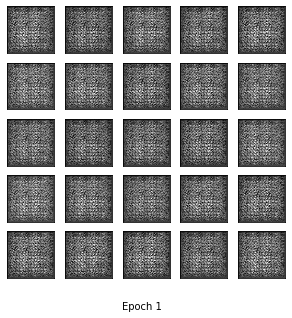

Iter : 0
D Loss : 0.0008454
G loss : 17.7

Iter : 0
D Loss : 0.005112
G loss : 8.47

Iter : 0
D Loss : 0.7527
G loss : 50.36

Iter : 0
D Loss : 15.07
G loss : 41.5

Iter : 0
D Loss : 6.727e-06
G loss : 25.75

Iter : 0
D Loss : 2.484
G loss : 39.87

Iter : 0
D Loss : 0.03042
G loss : 41.44

Iter : 0
D Loss : 0.5606
G loss : 27.62

Iter : 0
D Loss : 0.2483
G loss : 28.87

Iter : 0
D Loss : 0.01451
G loss : 24.44

Iter : 0
D Loss : 0.2874
G loss : 28.81

Iter : 0
D Loss : 1.776
G loss : 1.085

Iter : 0
D Loss : 17.68
G loss : 32.17

Iter : 0
D Loss : 0.0005762
G loss : 34.14

Iter : 0
D Loss : 0.08696
G loss : 29.92

Iter : 0
D Loss : 0.1129
G loss : 19.47

Iter : 0
D Loss : 0.1137
G loss : 8.703

Iter : 0
D Loss : 5.664
G loss : 31.07

Iter : 0
D Loss : 10.43
G loss : 19.82

Iter : 0
D Loss : 0.2918
G loss : 5.5

Iter : 0
D Loss : 5.047
G loss : 10.55

Iter : 0
D Loss : 0.2249
G loss : 10.8

Iter : 0
D Loss : 0.7752
G loss : 5.875

Iter : 0
D Loss : 4.343
G loss : 10.03

Iter : 0
D Loss 

In [ ]:
for it in range(15):
    show_result((it + 1))
    
    for iter in range(mnist.train.num_examples // 100):
        
        x_ = train_set[iter*100: (iter + 1)*100]
        
        _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict = {x: x_, z: sampleZ(100), isTrain: True})
        
        _, G_loss_curr = sess.run([G_solver, G_loss], feed_dict={z: sampleZ(100), isTrain: True})
        
        print('Iter : {}'.format(it))
        print('D Loss : {:.4}'.format(D_loss_curr))
        print('G loss : {:.4}'.format(G_loss_curr))
        print()